In [75]:
import MEArec as mr # what we will use to create a synthetic recording
import spikeinterface.full as si  # what we will use to sort the spikes
import matplotlib.pyplot as plt # for plots 
import math # for calculating 
import numpy as np
import pandas as pd
import scipy
import yaml # to open parameter files 
import warnings
from probeinterface.plotting import plot_probe

In [2]:
cell_folder = "C:\\Users\\melin\\Anaconda3\\envs\\si_env\\Lib\\site-packages\\MEArec\\cell_models\\bbp" # folder where we downloaded some cell models (13)
working_folder = "C:\\Users\\melin\\Desktop\\COURS_M2_CNN\\Projet\\" # the current folder 
param_folder = working_folder + 'params_locations\\' # where we put they yaml files with all the parameters
files_folder = working_folder + 'temporary_files_locations\\' # where we want to put the created files 
param_ext = '.yml' # yaml files contain dictionaries for our parameters 
files_ext = ".h5" # h5 files are created to save what we do 
parallel_compute = 4 # number of parallel processing that will be ongoing for heavy process 
real_data = working_folder + 'data_real\\templates_median.npy'

In [3]:
def parameters_modification(param_folder, list_changes) : 
    parameters = {
    'templates' :{} , 
    'spiketrains' : {},
    'recordings' : {}
}
    # We read the yaml file for the templates and extract information about the probe 
    with open(f"{param_folder}templates{param_ext}") as file:
        try:
            parameters['templates'] = yaml.safe_load(file)
            for elt in list_changes['templates'] :
                if elt in parameters['templates'] :
                    parameters['templates'][elt] = list_changes['templates'][elt] 
                else :
                    print('parameter not found')
            probe_spe = parameters['templates']['probe']
        except yaml.YAMLError as exception:
            print(exception)

    # We read the yaml file for the spiketrains and extract information about the number of neurons and the duration 
    with open(f"{param_folder}spiketrains{param_ext}") as file:
        try:
            parameters['spiketrains'] = yaml.safe_load(file)
            for elt in list_changes['spiketrains'] :
                if elt in parameters['spiketrains'] :
                    parameters['spiketrains'][elt] = list_changes['spiketrains'][elt] 
                else :
                    print('parameter not found')
            number_neurons = parameters['spiketrains']['n_exc'] + parameters['spiketrains']['n_inh']
            duration = parameters['spiketrains']['duration']
        except yaml.YAMLError as exception:
            print(exception)

    # We read the yaml file for the recordings and extract information about the drift
    with open(f"{param_folder}recordings{param_ext}") as file:
        try:
            parameters['recordings']= yaml.safe_load(file)
            for elt in list_changes['recordings'] :
                if elt in parameters['recordings'] :
                    parameters['recordings'][elt] = list_changes['recordings'][elt] 
                else :
                    print('parameter not found')
            if parameters['recordings']['drifting'] :
                drift = True  
                start = parameters['recordings']['t_start_drift']
            else :
                drift = False 
        except yaml.YAMLError as exception:
            print(exception)

    # We print the relevant information 
    print(f"We create a recording with {number_neurons} neurons, lasting {duration} seconds, from a {probe_spe} probe")
    if drift : 
        print(f"The drift starts after {start} seconds")

    return (parameters)


Here, we generate templates with parameters defined in a yaml file:
- what probe we wante to use
- the min/max locations of each neuron
- the number of templates for each cell model 
- the drift, if drift = True, we will have multiple templates for each cell at multiple drift steps 

We create some spike trains (for a chosen number of excitatory/inhibitory neurons and their firing rates) for a specified duration 
Then based on the templates and the spike trains generated, we can create a recording with again different parameters (noise, constraints on the templates, drift...)

In [4]:
def generation_and_saving(params, files_folder, spe='') : 

    with warnings.catch_warnings():
        warnings.simplefilter("ignore") # There are a lot of deprecation warnings that make the ouput not very easy to read, so we ignore them for now 

        tempgen = mr.gen_templates(cell_models_folder=cell_folder, params=params['templates'], n_jobs=parallel_compute, verbose=False)
        
        # Then we save the generated template in the output folder put in 'filename'
        mr.save_template_generator(tempgen, filename=f"{files_folder}templates{spe}{files_ext}", verbose = False)


        spgen = mr.gen_spiketrains(params=params['spiketrains'], verbose=False)

        recgen = mr.gen_recordings(params=params['recordings'], spgen = spgen, tempgen=tempgen, n_jobs=parallel_compute, verbose=False)

        # We also save the recording 
        mr.save_recording_generator(recgen, filename=f"{files_folder}recordings{spe}{files_ext}", verbose=False)
    
    return tempgen, spgen, recgen 


We read the different parameters files to extract relevant information, as the probe used, the number of neurons, the duration of the recording, or if there is a drift

Now that the recording is ready, we open it with spike interface

In [5]:
def load_in_spike_interface(files_folder, spe='') :
    return si.read_mearec(f"{files_folder}recordings{spe}{files_ext}")


From all the generated templates, some were randomly chosen to create our recording, we recover their identification numbers here

Using the monopolar triangulation method, spike interface estimates the position of the different units 

In [6]:
def templates_in_recording (recgen) :
    template_ids = recgen.template_ids
    n_templates = len(template_ids)
    return template_ids, n_templates

In [7]:
def predicted_locations (recording_si, sorting_si, n_templates, files_folder, spe='', method = 'monopolar_triangulation') :
    locations_pred =  [0]*n_templates
    for num in range (n_templates) :
        sorting_num = sorting_si.select_units([f"#{num}"]) # we create a sorting with only one unit 
        # Then we extract the waveforms corresponding to this unit 
        wv_num = si.extract_waveforms(recording = recording_si, sorting= sorting_num, overwrite= False, folder=f"{files_folder}//waveforms//wv{spe}_{num}", load_if_exists=True, max_spikes_per_unit=None)
        
        locations_pred[num]  = si.compute_spike_locations(wv_num, method = method) # finally there is the localization of each extracted waveform
    return (locations_pred)

Then, we compare the real position of each unit (large dots) from MEArec with  all the predictions (small dots) made by spike interface.

In [117]:
def plot_distances (tempgen, locations_pred, n_templates, template_ids, probe, n_to_plot = 15) :
    
    colors = ['green', 'cadetblue', 'mediumblue', 'slateblue', 'purple', 'plum', 'lightpink', 'gold', 'tomato', 'red', 'darkred', 'saddlebrown', 'black', 'grey', 'white']
    fig, ax = plt.subplots(1, 1, figsize=(6,8))
    plot_probe(probe, ax=ax)

    errors = [0]*n_templates
    dot_refs_x = [0]*n_templates
    dot_refs_y = [0]*n_templates
    alpha = []
    z = []
    alpha_mean = [0]*n_templates

    for num in range (n_templates) :

        dot_refs_x[num] = tempgen.locations[template_ids[num]][1] # This is the 'real' position of the unit from mearec 
        dot_refs_y[num] = tempgen.locations[template_ids[num]][2]
        
        x = []
        y = []
        errors[num] = [0]*len(locations_pred[num])

        a = []
        for t in range (len(locations_pred[num])) :
            dot_pred = locations_pred[num][t][0], locations_pred[num][t][1] # this is the prediction made by spike interface 
            z.append(locations_pred[num][t][2])
            alpha.append(locations_pred[num][t][3]) 
            a.append(locations_pred[num][t][3])
            x.append(dot_pred[0])
            y.append(dot_pred[1])   
            errors[num][t] = math.dist(dot_pred, (dot_refs_x[num], dot_refs_y[num])) # We compute the distance between the real position and the prediction (norm 2)
        
        alpha_mean[num] = np.mean(a)
        if num < 10 : # We only show a maximum of 10 units so the plot is easier to read 
            plt.scatter(x, y, s = 20, edgecolors= 'none', color = colors[num]) # the predictions are represented by small dots 
        

    n_plot = min(n_templates, n_to_plot)
    # the real positions are represented by larger dots circled in black

    plt.scatter(dot_refs_x[:n_plot], dot_refs_y[:n_plot], s=100, color = colors[:n_plot], edgecolors= 'black')  
    plt.title('Predictions vs positions')
    plt.xlabel('x coordinate in um')
    plt.ylabel('y coordinate in um')
    plt.show()

    return(errors, alpha, z, alpha_mean)



We can see qualitatively on the above plot that the predictions are not always around the real position. We computed in the precedent loop the distances between the predictions and the reality. We can now plot them to evaluate quantitavely the precision of the monopolar triangulation method. 

In [118]:
def boxplot_errors(errors, n_templates, n_to_plot = 15) :
        colors = ['green', 'cadetblue', 'mediumblue', 'slateblue', 'purple', 'plum', 'lightpink', 'gold', 'tomato', 'red', 'darkred', 'saddlebrown', 'black', 'grey', 'white']
        mean_errors = [0]*n_templates
        n_plot = min(len(errors), n_to_plot)

        fig = plt.figure(figsize =(12, 8))
        ax = plt.subplot()
        bp = plt.boxplot(errors[:n_plot], 0, '', patch_artist=True)
        ax.set_xticklabels([f"#{i}" for i in range (n_plot)]) # We only show a maximum of 10 boxplots for readibility
        ax.set_ylabel('Prediction error in um')
        ax.set_xlabel('Templates')
        ax.set_title('Distance between template position and spike location')

        for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)

        mean_errors = [np.mean(errors[i]) for i in range (n_templates)]
                
        plt.show()
        return(mean_errors)

The location error varies greatly between the different templates, we will now try to understand why. We can test the correlation between the error and different features: 
- the variation of the peak to peak ratios betweeen the different probes for each template
- the frobenius norm of each template matrix 

In [114]:
def templates_info(templates, template_ids, n_templates, spe = ""):
    
    peak_to_peak_var = [0]*n_templates
    frob_norms = [0]*n_templates

    for i, template_id in enumerate(template_ids) :
        n_probe = len(templates[0])
        peak_to_peak = [0]*n_probe
        for probe in range (n_probe) :
            peak_to_peak[probe] = np.max(templates[template_id][probe][:]) - np.min(templates[template_id][probe][:])
        peak_to_peak_var[i] = np.var(peak_to_peak)
        frob_norms[i] = np.linalg.norm(templates[template_id])

    return(peak_to_peak_var,frob_norms)

In [11]:
def excitatory_or_inhibitory(tempgen, template_ids, n_templates) :
    exc_num = []
    inh_num = []
    exc = ['STPC', 'TTPC1', 'TTPC2', 'UTPC'] 
    inh = ['BP', 'BTC', 'ChC', 'DBC', 'LBC', 'MC', 'NBC', 'NGC', 'SBC']
    for num in range (n_templates) :
        for celltype in exc :
            if celltype in tempgen.celltypes[template_ids[num]] :
                exc_num.append(num)
        for celltype in inh :
            if celltype in tempgen.celltypes[template_ids[num]] :
                inh_num.append(num)
                
    return(exc_num, inh_num)

In [12]:
def plot_error_vs_y (mean_errors, y_to_plot, y_titles, tempgen, template_ids, n_templates, spe=''):
    fig, ax = plt.subplots(len(y_titles), figsize = (8,10))

    fig.suptitle = 'Plot ' + spe 
    exc_num, inh_num = excitatory_or_inhibitory(tempgen, template_ids, n_templates)
    for n, y in enumerate(y_to_plot) :
        for num in exc_num :
            ax[n].scatter(mean_errors[num], y[num], color = 'green')
        for num in inh_num :
            ax[n].scatter(mean_errors[num], y[num], color = 'red')
        ax[n].set_title(y_titles[n])
    plt.show()
    return()

In [13]:
def plot_error_vs_y_all (mean_errors, y_to_plot, y_titles, tempgen, recgen, probes, shapes):

    f , ax = plt.subplots(len(y_titles), figsize = (8,10))

    for pr in range (len(probes)) :
        template_ids, n_templates = templates_in_recording (recgen[pr])
        exc_num, inh_num = excitatory_or_inhibitory(tempgen[pr], template_ids, n_templates)

        for n, y in enumerate(y_to_plot[pr]) :
            for num in exc_num :
                ax[n].scatter(mean_errors[pr][num], y[num], color = 'green', marker= shapes[pr])
            for num in inh_num :
                ax[n].scatter(mean_errors[pr][num], y[num], color = 'red', marker= shapes[pr])
            ax[n].set_title(y_titles[n])

    plt.show()
    return()

In [14]:
def boxplot_probes(mean_errors, probes) :
    ax = plt.subplot()
    ax.boxplot(mean_errors)
    ax.set_xticklabels(probes)
    ax.set_ylabel('Distance with real position in um')
    ax.set_title('Mean location errors for different probes')
    return()

In [69]:
list_changes = {
    'templates' :{} , 
    'spiketrains' : {},
    'recordings' : {}
}

probes = ['Fake_probe']

tempgen = [0]*len(probes)
spgen = [0]*len(probes)
recgen = [0]*len(probes)

for pr, probe in enumerate(probes) :
    list_changes['templates'] = {'probe' : probe}
    spe = probe 

    params = parameters_modification(param_folder, list_changes)

    print(f"parameters successfully modified for {spe}")

    tempgen[pr], spgen[pr], recgen[pr] = generation_and_saving(params, files_folder, spe = spe)

    print(f"Generation done for {spe}")

We create a recording with 60 neurons, lasting 30 seconds, from a Fake_probe probe
parameters successfully modified for Fake_probe
Aggregating templates



Simulation time: 374.9245812892914



Generation done for Fake_probe


In [70]:

probes = ['Neuropixels-128', 'Fake_probe']
shapes = ["o", "^", "s"]

tempgen = [0]*len(probes)
recgen = [0]*len(probes)

locations_pred = [0]*len(probes)

for pr, probe in enumerate(probes) :
    spe = probe

    tempgen[pr] = mr.load_templates(f"{files_folder}templates{spe}{files_ext}")
    recgen[pr] = mr.load_recordings(f"{files_folder}recordings{spe}{files_ext}")

    recording_si, sorting_si = load_in_spike_interface(files_folder, spe = spe)

    template_ids, n_templates = templates_in_recording(recgen[pr])

    locations_pred[pr] = predicted_locations(recording_si, sorting_si, n_templates, files_folder, spe = spe)

    print(f"locations found for {spe}")

    

locations found for Neuropixels-128
locations found for Fake_probe


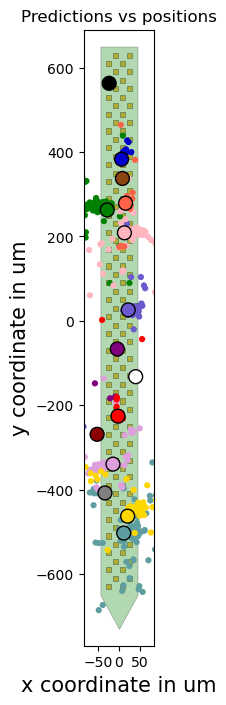

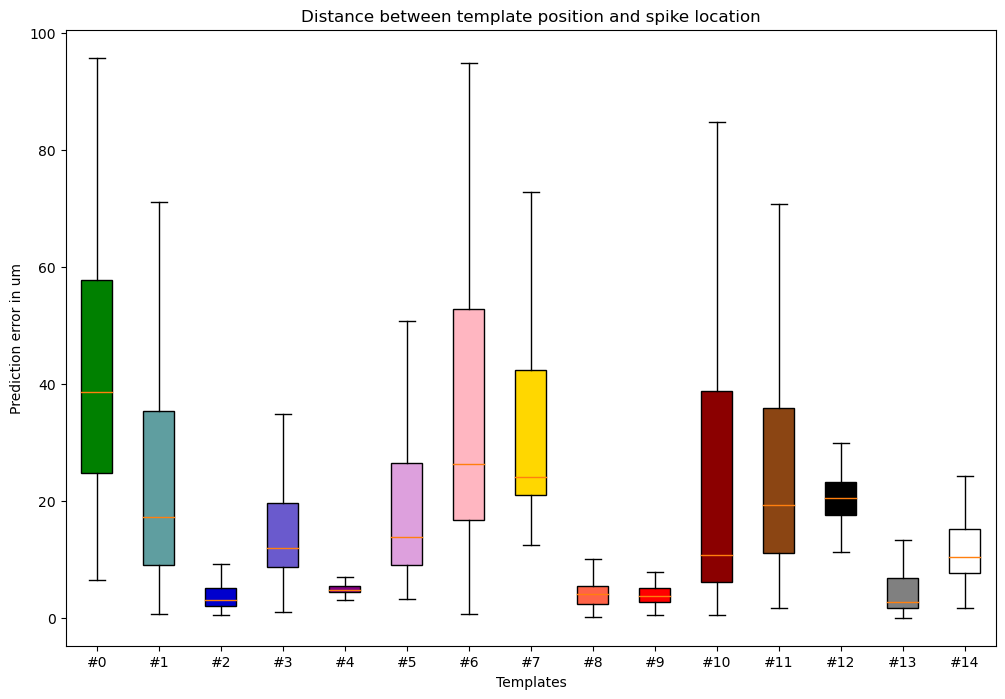

Neuropixels-128_ The peak to peak ratios variability are correlated at -0.4313087645823065 with the error
Neuropixels-128_ The Frobenius norms are correlated at -0.55538787907457 with the error


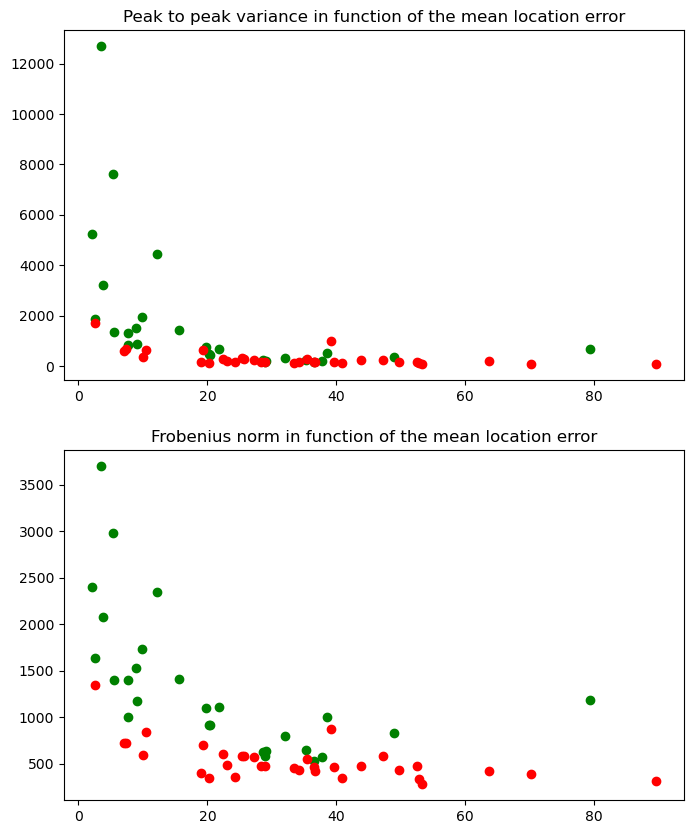

All done for Probe - 128ch - 1shanks


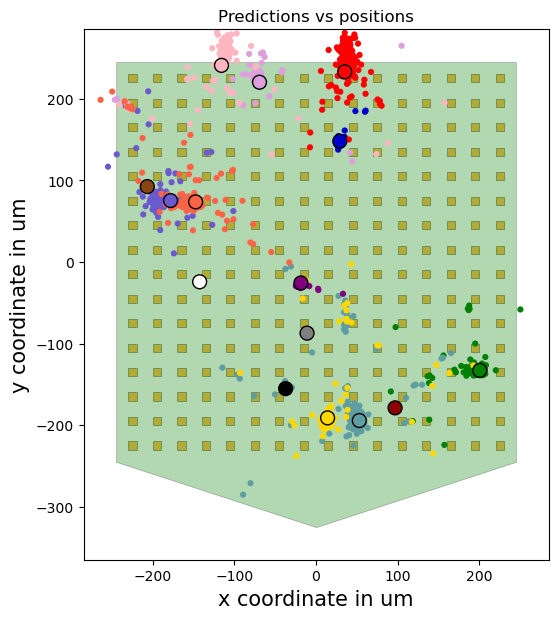

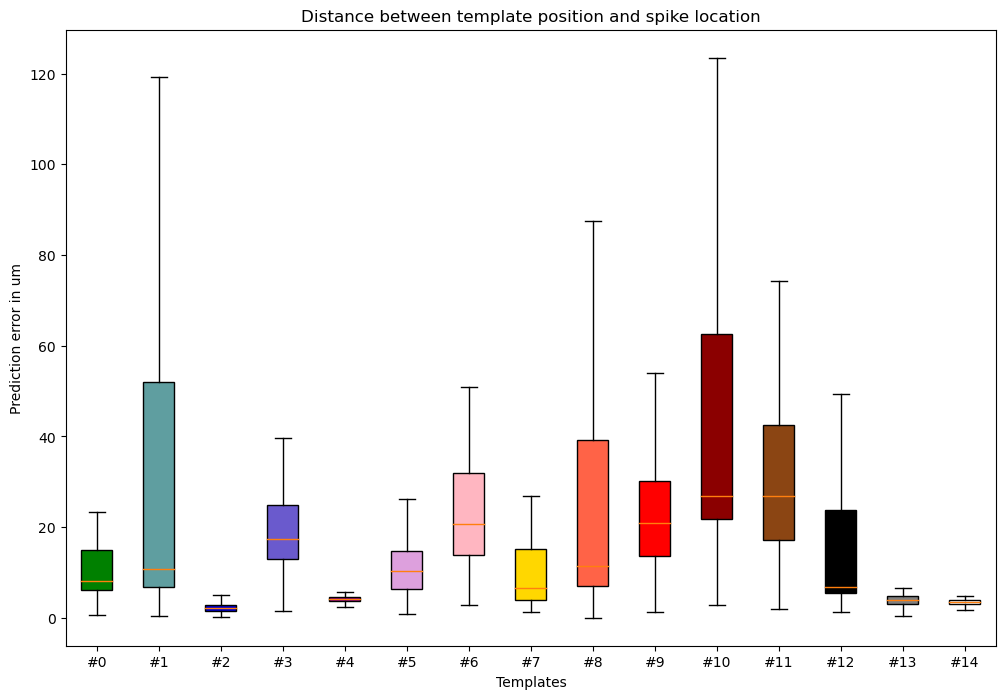

Fake_probe_ The peak to peak ratios variability are correlated at -0.417765745441375 with the error
Fake_probe_ The Frobenius norms are correlated at -0.5173321266992822 with the error


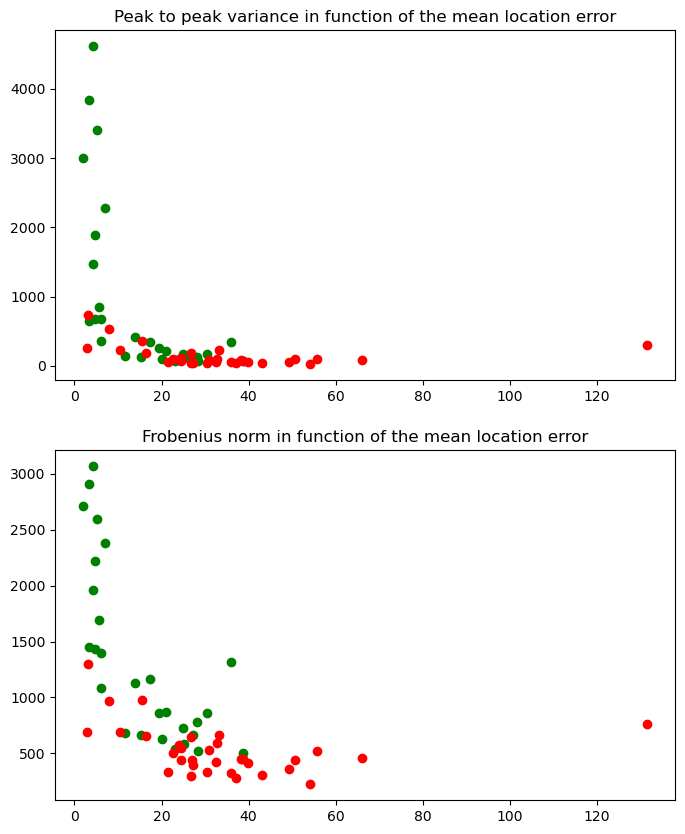

All done for Probe - 256ch - 1shanks


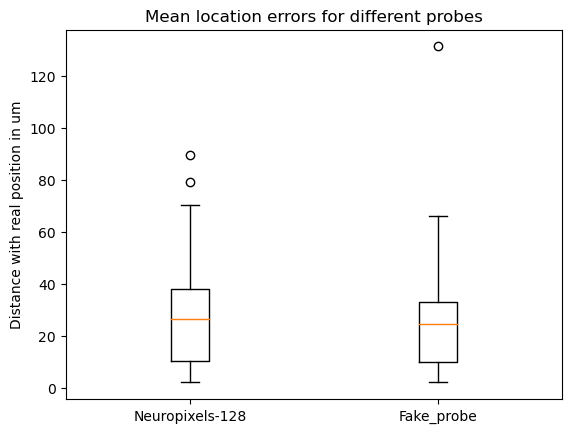

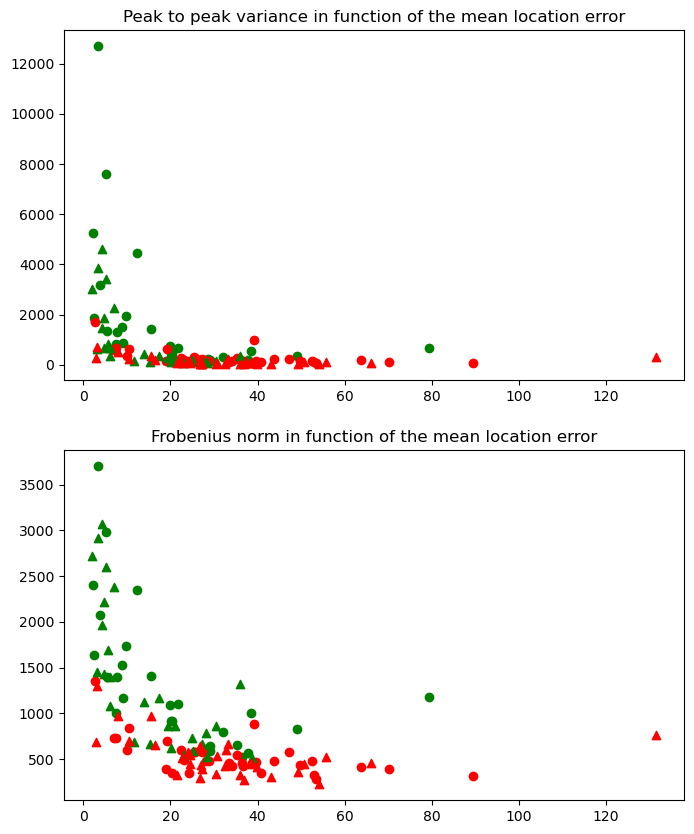

()

In [119]:
mean_errors = [0]*len(probes)
peak_to_peak_var = [0]*len(probes)
frob_norms = [0]*len(probes)
alpha_values = [0]*len(probes)
alpha_mean = [0]*len(probes)
z_values = [0]*len(probes)
y_to_plot = [0]*len(probes)

for pr, probe in enumerate(probes) :
    spe = probe

    tempgen[pr] = mr.load_templates(f"{files_folder}templates{spe}{files_ext}")
    recgen[pr] = mr.load_recordings(f"{files_folder}recordings{spe}{files_ext}")

    recording_si, sorting_si = load_in_spike_interface(files_folder, spe = spe)

    template_ids, n_templates = templates_in_recording(recgen[pr])

    probe = recording_si.get_probe()
    
    errors, alpha_values[pr], z_values[pr], alpha_mean[pr] = plot_distances(tempgen[pr], locations_pred[pr], n_templates, template_ids, probe)

    mean_errors[pr] = boxplot_errors(errors, n_templates)

    templates = tempgen[pr].templates

    peak_to_peak_var[pr], frob_norms[pr] = templates_info(templates, template_ids, n_templates, spe=spe)

    print(f"{spe}_ The peak to peak ratios variability are correlated at {np.corrcoef(mean_errors[pr], peak_to_peak_var[pr])[0][1]} with the error")
    print(f"{spe}_ The Frobenius norms are correlated at {np.corrcoef(mean_errors[pr], frob_norms[pr])[0][1]} with the error")

    y_to_plot[pr] = [peak_to_peak_var[pr], frob_norms[pr]]

    end_title = 'in function of the mean location error'

    y_titles = ['Peak to peak variance ' + end_title, 'Frobenius norm ' + end_title]

    plot_error_vs_y(mean_errors[pr], y_to_plot[pr], y_titles, tempgen[pr], template_ids, n_templates, spe=spe)

    print(f"All done for {probe}")

boxplot_probes(mean_errors, probes)
plot_error_vs_y_all(mean_errors, y_to_plot, y_titles, tempgen, recgen, probes, shapes)

Text(0.5, 0, 'Alpha (uV)')

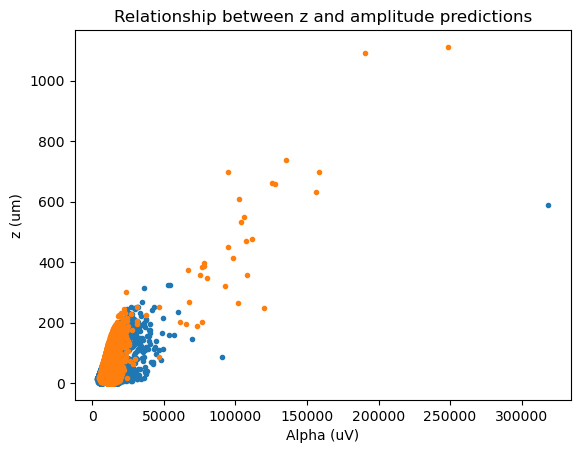

In [128]:
for pr in range (len(probes)) :
    plt.scatter(alpha_values[pr],z_values[pr], marker = '.')

plt.title('Relationship between z and amplitude predictions')
plt.ylabel('z (um)')
plt.xlabel('Alpha (uV)')


In [127]:
templates_real = np.load(real_data)
n_templates_real = len(templates_real)
template_ids_real = range(n_templates_real)
n_channels = len(templates_real[0][0])
n_time = len(templates_real[0])

print(f"We loaded data from {n_templates_real} templates, each sampled {n_time} times on {n_channels} channels")
# templates real is n_templates * n_time * n_channels
# We want n_templates * n_channels * n_time 

templates_real_reversed = [0]*n_templates_real 
for template in template_ids_real :
    templates_real_reversed[template] = [0]*n_channels
    for channel in range (n_channels) :
        templates_real_reversed[template][channel] = [0]*n_time
        for time in range (n_time) :
            templates_real_reversed[template][channel][time] = templates_real[template][time][channel]

peak_to_peak_var_real, frob_norms_real = templates_info(templates_real_reversed, template_ids_real, n_templates_real)


We loaded data from 267 templates, each sampled 140 times on 252 channels


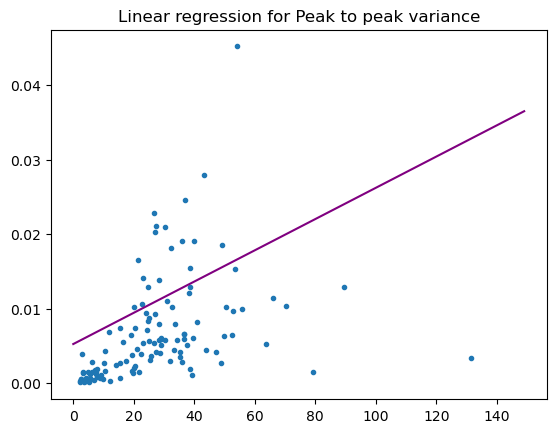

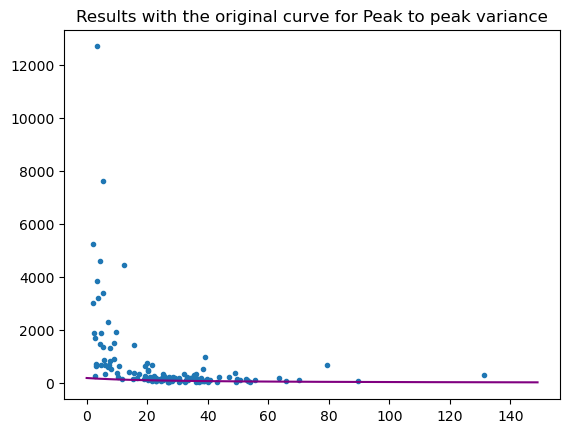

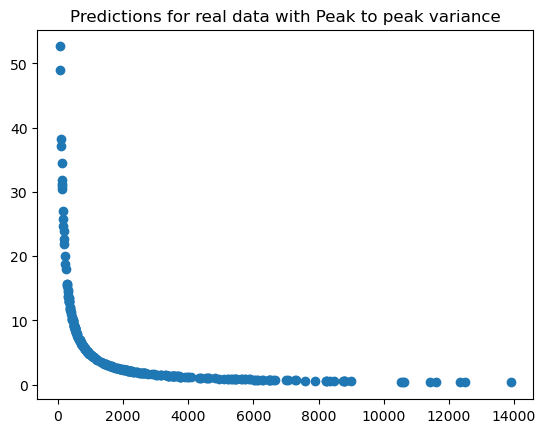

The mean error for Peak to peak variance is 2727.056288749545
There are 37% of templates for which we predicted an error inferior to 1000 um using the Peak to peak variance


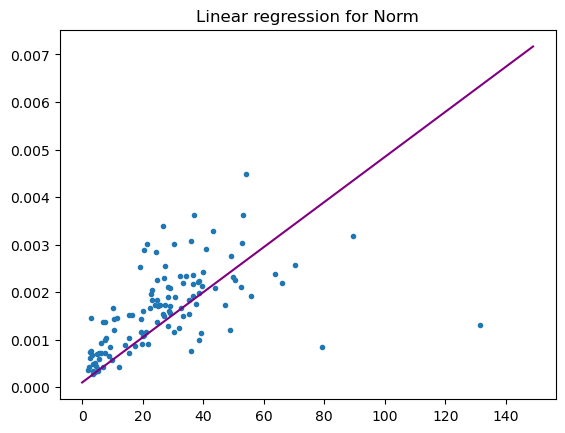

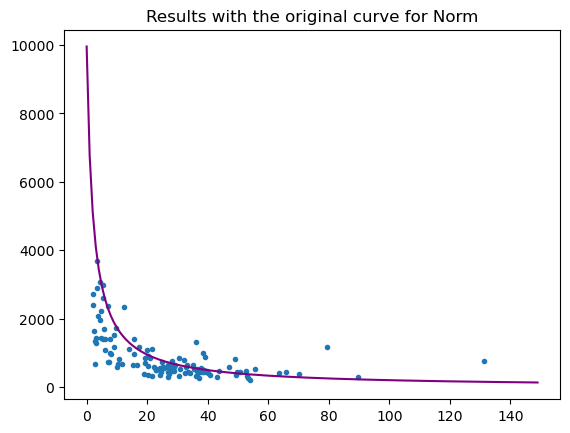

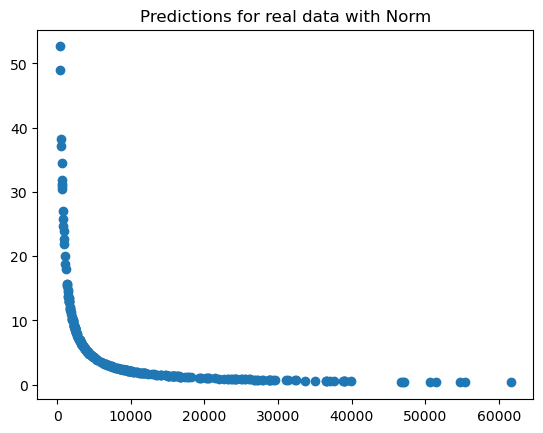

The mean error for Norm is 12173.841207936295
There are 5% of templates for which we predicted an error inferior to 1000 um using the Norm


In [126]:
attributes_to_use = [0,1]
labels_attributes = ['Peak to peak variance', 'Norm']

for attribute in attributes_to_use :

    x = []
    y = []

    for pr in range (len(probes)) :
        for i in range (len(mean_errors[pr])) :
            x.append([mean_errors[pr][i]])   
        for i in range (len(y_to_plot[pr][attribute])) :
            y.append(y_to_plot[pr][attribute][i])
            
        
    ybis = [1/yi for yi in y]

    plt.scatter(x,ybis, marker = '.')

    xarray = np.array(x)
    ybisarray = np.array(ybis)
    model = np.linalg.lstsq(xarray,ybisarray, rcond=None)
    a = model[0][0]
    b = model[1][0]

    xp = range(150)
    yp = [a*xi + b for xi in xp]

    plt.plot(xp,yp, color = 'purple')
    plt.title(f'Linear regression for {labels_attributes[attribute]}')

    plt.show()


    yr = [1/(a*xi+b) for xi in xp]

    plt.scatter(x,y, marker = '.')
    plt.plot(xp,yr, color = 'purple')
    plt.title(f'Results with the original curve for {labels_attributes[attribute]}')
    plt.show()


    x_predicted = [(1/yi - b)/a for yi in peak_to_peak_var_real]

    plt.scatter(x_predicted, peak_to_peak_var_real)
    plt.title(f'Predictions for real data with {labels_attributes[attribute]}')
    plt.show()

    print(f"The mean error for {labels_attributes[attribute]} is {np.mean(x_predicted)}")

    max_error = 1000
    l = [1 for x in x_predicted if x < max_error ]
    print(f"There are {int(sum(l)*100/n_templates_real)}% of templates for which we predicted an error inferior to {max_error} um using the {labels_attributes[attribute]}")

In [74]:
print(f"The peak to peak variance varies between {min(peak_to_peak_var_real)} and {max(peak_to_peak_var_real)} for the real data, compared to {min([min(peak_to_peak_var[i]) for i in range (len(peak_to_peak_var))])} and {max([max(peak_to_peak_var[i]) for i in range (len(peak_to_peak_var))])} for artifical data")
 
print(f"The norm varies between {min(frob_norms_real)} and {max(frob_norms_real)} for the real data, compared to {min([min(frob_norms[i]) for i in range (len(frob_norms))])} and {max([max(frob_norms[i]) for i in range (len(frob_norms))])} for artifical data")


The peak to peak variance varies between 0.3420749604701996 and 52.627685546875 for the real data, compared to 22.12454290683097 and 12693.506233086802 for artifical data
The norm varies between 28.000280380249023 and 266.70623779296875 for the real data, compared to 222.91954478696385 and 3701.9286506288836 for artifical data
